In [3]:
import pandas as pd
import gzip
import re
import numpy as np
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from sklearn import linear_model
## seaborn for plotting
import seaborn as sns
sns.set(font_scale=1.2, style="white")

# import matplotlib for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('inaugural')

In [41]:
df_rent = pd.read_json("./dataset/renttherunway_final_data.json", lines=True)

# missing value

In [48]:
df_rent

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192539,fit,66386,34dd,2252812,140lbs,10.0,work,Fit like a glove!,hourglass,LOVE IT!!! First Item Im thinking of buying!,jumpsuit,"5' 9""",8,42.0,"May 18, 2016"
192540,fit,118398,32c,682043,100lbs,10.0,work,The pattern contrast on this dress is really s...,petite,LOVE it!,dress,"5' 1""",4,29.0,"September 30, 2016"
192541,fit,47002,36a,683251,135lbs,6.0,everyday,"Like the other DVF wraps, the fit on this is f...",straight & narrow,"Loud patterning, flattering fit",dress,"5' 8""",8,31.0,"March 4, 2016"
192542,fit,961120,36c,126335,165lbs,10.0,wedding,This dress was PERFECTION. it looked incredib...,pear,loved this dress it was comfortable and photog...,dress,"5' 6""",16,31.0,"November 25, 2015"


In [50]:
print(df_rent.isnull().sum(axis=0))

fit                   0
user_id               0
bust size         18411
item_id               0
weight            29982
rating               82
rented for           10
review_text           0
body type         14637
review_summary        0
category              0
height              677
size                  0
age                 960
review_date           0
dtype: int64


In [46]:
print("The number of missing review text is {}".format(df_rent['review_text'].isnull().sum()))
print("The number of missing review summary is {}".format(df_rent['review_summary'].isnull().sum()))

The number of missing review text is 0
The number of missing review summary is 0


Since we want to find what affects rating, we will drop the rows with missing rating

In [53]:
df = df_rent.dropna(inplace=False, subset = ['rating'], how='any')

Distribution of the rating

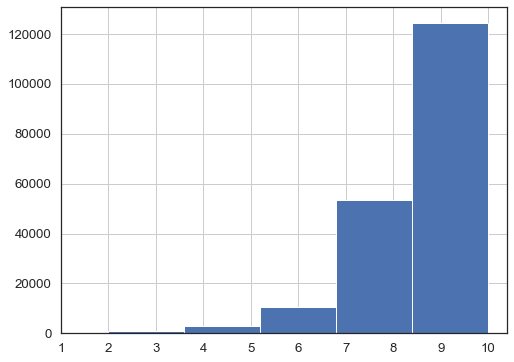

In [58]:
# Distribution of the rating
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
df['rating'].hist(bins=5)
plt.xticks(np.arange(1,11,step=1))
plt.show()

In [5]:
# dataset = [d for d in dataset if d['helpful'][1] != 0]

In [9]:
df_raw = pd.DataFrame(data = dataset)
df_raw.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1.0,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3.0,OK Palette!,1397779200,"04 18, 2014"
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4.0,great quality,1378425600,"09 6, 2013"
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2.0,Do not work on my face,1386460800,"12 8, 2013"
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3.0,It's okay.,1382140800,"10 19, 2013"


# data cleaning

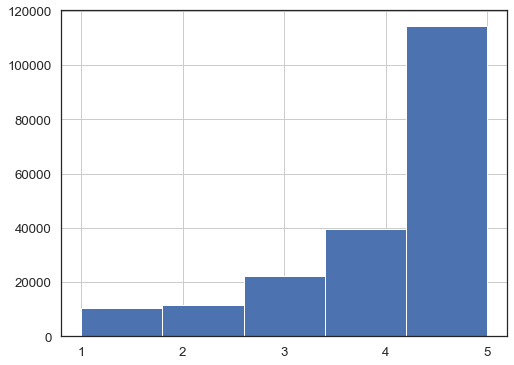

In [10]:
# Distribution of the rating
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
df_raw['overall'].hist(bins=5)
plt.xticks(np.arange(1,6,step=1))
plt.show()

We can see it is not normally distributed but skewed to left

In [ ]:
df = df_raw
df['sentiment'] = df['overall'].apply(lambda x: 1 if x >=3)

In [ ]:
'not' 'without'

AttributeError: 'WordListCorpusReader' object has no attribute 'word'

In [8]:
'isn\'t' in nltk.corpus.stopwords.words('english')

True

In [10]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1.0,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3.0,OK Palette!,1397779200,"04 18, 2014"
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4.0,great quality,1378425600,"09 6, 2013"
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2.0,Do not work on my face,1386460800,"12 8, 2013"
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3.0,It's okay.,1382140800,"10 19, 2013"


In [27]:
# remove null helpful



([<matplotlib.axis.XTick at 0x22718266c10>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

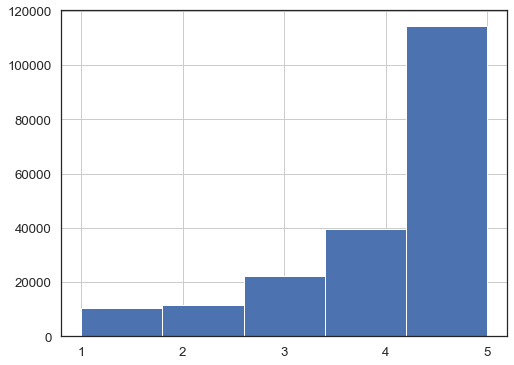

In [ ]:
sum([a==b for a,b in zip(arr1,arr2)]) / len(arr1)

In [46]:
text = [re.sub(r'[^A-Za-z0-9]+',' ', t) for t in [d['reviewText'] for d in dataset]]
for i in range(len(text)):
    text[i] = text[i].lower()

In [64]:
# your code here
tfidf = TfidfVectorizer(sublinear_tf=True,
                        analyzer = "word",
                        max_features=2000,
                        tokenizer=word_tokenize,
                        stop_words=stopwords.words("english"))

In [ ]:
# bigger then 0.5 is useful
# 
threshold = 0.5

In [141]:
Y = [1 if d['helpful'][0]/d['helpful'][1] >= 0.5 else 0 for d in dataset]

In [146]:
X_text_train, Y_train = text[:70000], Y[:70000]
X_text_valid, Y_valid = text[70000:], Y[70000:]
X_train = tfidf.fit_transform(X_text_train)
X_valid = tfidf.transform(X_text_valid)

In [148]:
tfidf_df = pd.DataFrame(data = X_train.todense())

In [149]:
tfidf_df.index = Y_train

In [150]:
tfidf_df.columns = tfidf.get_feature_names()

In [151]:
most_unique = tfidf_df.idxmax(axis = 1)

In [120]:
mod = linear_model.LinearRegression()

In [121]:
mod.fit(X_train, Y_train)

LinearRegression()

In [122]:
Y_pred_valid  = mod.predict(X_valid)

In [124]:
MSE = sum([(a-b)**2 for a,b in zip(Y_pred_valid, Y_valid)]) / len(Y_valid)

In [125]:
MSE

0.1386672330422749

In [139]:
Y_pred_valid[0]

0.629093518227114

In [145]:
dataset[0]

{'reviewerID': 'A1YJEY40YUW4SE',
 'asin': '7806397051',
 'reviewerName': 'Andrea',
 'helpful': [3, 4],
 'reviewText': 'Very oily and creamy. Not at all what I expected... ordered this to try to highlight and contour and it just looked awful!!! Plus, took FOREVER to arrive.',
 'overall': 1.0,
 'summary': "Don't waste your money",
 'unixReviewTime': 1391040000,
 'reviewTime': '01 30, 2014'}

In [140]:
dataset[0]

{'reviewerID': 'A1YJEY40YUW4SE',
 'asin': '7806397051',
 'reviewerName': 'Andrea',
 'helpful': [3, 4],
 'reviewText': 'Very oily and creamy. Not at all what I expected... ordered this to try to highlight and contour and it just looked awful!!! Plus, took FOREVER to arrive.',
 'overall': 1.0,
 'summary': "Don't waste your money",
 'unixReviewTime': 1391040000,
 'reviewTime': '01 30, 2014'}